In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random 
from tqdm import tqdm
from data_utils.load_cora import *
from data_utils.load_pubmed import *

import torch.nn.functional as F
from torch_geometric.nn import GCNConv

/home/kshou/miniconda3/envs/gnn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed=0):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    np.random.seed(seed)  
    random.seed(seed)

# 
set_seed(0)

def freeze_unfreeze_bert(model, tune_last_n=4):
    # freeze whole bert
    for param in model.parameters():
        param.requires_grad = False
    
    # unfreeze last 4 layers
    for param in model.encoder.layer[-tune_last_n:].parameters():
        param.requires_grad = True
    
    return model

In [3]:
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, num_classes, num_layers=2):
        super().__init__()
        assert num_layers >= 2
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(GCNConv(in_dim, hid_dim, cached=True))       # first layer
        
        for _ in range(num_layers - 2):
            self.conv_layers.append(GCNConv(hid_dim, hid_dim, cached=True))  # hidden layers
        
        self.conv_layers.append(GCNConv(hid_dim, num_classes, cached=True))   # last layer

    def forward(self, x, edge_index):   # x: node_feats, edge_index: [2, num_edges]
        for i, conv in enumerate(self.conv_layers[:-1]):
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv_layers[-1](x, edge_index)     # logit,    [N, num_classes]
        return x            

In [4]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', max_position_embeddings=512)

/home/kshou/miniconda3/envs/gnn/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/kshou/miniconda3/envs/gnn/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any fe

### Cora

In [4]:
# load Cora
data_cora, text_cora = get_raw_text_cora(use_text=True)
data_cora.num_classes = data_cora.y.max().item() + 1      # 7

In [5]:
class LM_GNN():                                    
    def __init__(self, lm_model, gnn_model, lm_optim, gnn_optim, t5=False):
        super().__init__()
        self.lm_model = lm_model
        self.gnn_model = gnn_model
        self.t5 = t5
        self.text_embed_dim = 768 if not t5 else 512

        self.optimizer_lm = lm_optim
        self.optimizer_gnn = gnn_optim

    def count_parameters(self):
        lm_total = sum(p.numel() for p in self.lm_model.parameters())
        gnn_total = sum(p.numel() for p in self.gnn_model.parameters())
        lm_trainable = sum(p.numel() for p in self.lm_model.parameters() if p.requires_grad)
        gnn_trainable = sum(p.numel() for p in self.gnn_model.parameters() if p.requires_grad)
        print(f'LM: {lm_trainable/1e6}M/{lm_total/1e6}M, {lm_trainable/lm_total*100:.2f}%')
        print(f'GNN: {gnn_trainable}/{gnn_total}, {gnn_trainable/gnn_trainable*100:.2f}%')
        
    def evaluate(self, data, text, bs_text=32, eval_split='test'):
        """inference with the LM->GNN pipeline"""
        assert eval_split in ['train', 'val', 'test']
        self.lm_model.eval()
        self.gnn_model.eval()
        
        with torch.no_grad():
            n_nodes = data.num_nodes
            text_embed = torch.zeros(n_nodes, self.text_embed_dim).to('cuda')       # N, 768
            for i in range(0, n_nodes, bs_text):
                inputs = {key: val[i:i+bs_text].clone().detach().to('cuda') for key, val in text.items()}
                lm_output = self.lm_model(**inputs)
                text_embed[i:i+bs_text] = lm_output.last_hidden_state[:, 0, :]
            
            logits = self.gnn_model(text_embed, data.edge_index)
            preds = logits.argmax(dim=1)
            mask = data[f'{eval_split}_mask']
            correct = (preds[mask] == data.y[mask]).sum()
            acc = int(correct) / int(mask.sum())
        return acc

    
    def train_one_epoch(self, data, text, bs_text=32):
        """
        Gradient descent both LM and GNN after full data forwarded (1 epoch=1 step update)
        Args:
            data: PyG data object
            text: dict of tokenized text inputs
            bs_text: batch size for text encoding (nothing to do with batch update, just for memory)
        """
        n_nodes = data.num_nodes
        self.lm_model.train()       # turn off the dropout in LM
        self.gnn_model.train()

        with torch.no_grad():
            # LM forward text
            text_embed = torch.zeros(n_nodes, self.text_embed_dim).to('cuda')        # N, 768
            torch.manual_seed(0)        # tackle the dropout in LM
            for i in range(0, n_nodes, bs_text):
                inputs = {key: val[i:i+bs_text].clone().detach().to('cuda') for key, val in text.items()}
                lm_output = self.lm_model(**inputs)
                if not self.t5:
                    text_embed[i:i+bs_text] = lm_output.last_hidden_state[:, 0, :]               # B, 768
                else:
                    text_embed[i:i+bs_text] = lm_output.last_hidden_state.mean(dim=1)            # B, 512

        # GNN with the node text embeddings
        text_embed.requires_grad = True
        gnn_output = self.gnn_model(text_embed, data.edge_index)                                   # N, K

        self.optimizer_gnn.zero_grad()
        loss_gnn = F.cross_entropy(gnn_output[data.train_mask], data.y[data.train_mask])
        loss = loss_gnn.item()
        loss_gnn.backward()

        # store the gradients of the node text embeddings
        text_embed_grad = text_embed.grad.clone().detach()       # N, 768

        self.optimizer_gnn.step()

        # LM second time forward (for backward grad and update)
        self.optimizer_lm.zero_grad()

        torch.manual_seed(0)        
        # gradient accumulation over all text batches (all nodes)
        for i in tqdm(range(0, n_nodes, bs_text)):
            inputs = {key: val[i:i+bs_text].clone().detach().to('cuda') for key, val in text.items()}
            lm_output = self.lm_model(**inputs)
            if not self.t5:
                text_embed_batch = lm_output.last_hidden_state[:, 0, :]                     # B, 768
            else:
                text_embed_batch = lm_output.last_hidden_state.mean(dim=1)                  # B, 512

            # grad from GNN loss, backward(grad) will accumulate gradients and release memory
            text_embed_batch.backward(text_embed_grad[i:i+bs_text])                     # B, 768

        self.optimizer_lm.step()

        return loss


In [7]:
set_seed(0)

gcn = GCN(768, 256, data_cora.num_classes, num_layers=2)
model_text = BertModel.from_pretrained('bert-base-uncased', max_position_embeddings=512)
model_text.pooler = nn.Identity()

lm_optimizer = torch.optim.AdamW(model_text.parameters(), lr=5e-5)
gcn_optimizer = torch.optim.AdamW(gcn.parameters(), lr=1e-3)

lm_gnn = LM_GNN(model_text.cuda(), gcn.cuda(), lm_optimizer, gcn_optimizer)
lm_gnn.count_parameters()

LM: 108.891648M/108.891648M, 100.00%
GNN: 198663/198663, 100.00%


In [8]:
set_seed(0)

# tokenize all texts
text_inputs = tokenizer(text_cora, return_tensors='pt', padding=True, truncation=True, max_length=512)          # dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
data_cora = data_cora.cuda()

# joint training
EPOCHS = 100
cora_epoch_loss_list = []

early_stop_ep = 6
epoch_no_improve = 0
val_ep = 2
best_val_acc = 0

for i in tqdm(range(EPOCHS)):
    epoch = i + 1
    
    loss = lm_gnn.train_one_epoch(data_cora, text_inputs, bs_text=48)
    
    print(f'Epoch {epoch} | Loss: {loss:.4f}')
    cora_epoch_loss_list.append(loss)
    
    if epoch % val_ep == 0:
        acc = lm_gnn.evaluate(data_cora, text_inputs, bs_text=48, eval_split='val')
        print(f'Epoch {epoch} | Val Acc: {acc:.4f}')

        if acc > best_val_acc:
            best_val_acc = acc
            epoch_no_improve = 0
        else:
            epoch_no_improve += val_ep
        
        if epoch_no_improve >= early_stop_ep:
            print(f'Early stopping at epoch {epoch}')
            break

  1%|          | 1/100 [01:18<2:09:04, 78.23s/it]

Epoch 1 | Loss: 2.1345


100%|██████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 2 | Loss: 2.1671


  2%|▏         | 2/100 [02:56<2:27:30, 90.31s/it]

Epoch 2 | Val Acc: 0.3100


  3%|▎         | 3/100 [04:15<2:17:20, 84.95s/it]

Epoch 3 | Loss: 1.8541


100%|██████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 4 | Loss: 1.8531


  4%|▍         | 4/100 [05:54<2:24:41, 90.44s/it]

Epoch 4 | Val Acc: 0.3155


  5%|▌         | 5/100 [07:12<2:16:24, 86.15s/it]

Epoch 5 | Loss: 1.8339


100%|██████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 6 | Loss: 1.7993


  6%|▌         | 6/100 [08:51<2:21:45, 90.48s/it]

Epoch 6 | Val Acc: 0.3100


  7%|▋         | 7/100 [10:10<2:14:12, 86.59s/it]

Epoch 7 | Loss: 1.7703


100%|██████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 8 | Loss: 1.7282


  8%|▊         | 8/100 [11:49<2:18:45, 90.49s/it]

Epoch 8 | Val Acc: 0.3376


  9%|▉         | 9/100 [13:07<2:11:34, 86.75s/it]

Epoch 9 | Loss: 1.6702


100%|██████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 10 | Loss: 1.5865


 10%|█         | 10/100 [14:46<2:15:42, 90.47s/it]

Epoch 10 | Val Acc: 0.3653


 11%|█         | 11/100 [16:05<2:08:43, 86.78s/it]

Epoch 11 | Loss: 1.4654


100%|██████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 12 | Loss: 1.3104


 12%|█▏        | 12/100 [17:43<2:12:38, 90.43s/it]

Epoch 12 | Val Acc: 0.6550


 13%|█▎        | 13/100 [19:02<2:05:52, 86.81s/it]

Epoch 13 | Loss: 1.1433


100%|██████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 14 | Loss: 0.9739


 14%|█▍        | 14/100 [20:41<2:09:36, 90.42s/it]

Epoch 14 | Val Acc: 0.7675


 15%|█▌        | 15/100 [21:59<2:02:58, 86.80s/it]

Epoch 15 | Loss: 0.8324


100%|██████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 16 | Loss: 0.6953


 16%|█▌        | 16/100 [23:38<2:06:33, 90.40s/it]

Epoch 16 | Val Acc: 0.8155


 17%|█▋        | 17/100 [24:56<2:00:05, 86.82s/it]

Epoch 17 | Loss: 0.5996


100%|██████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 18 | Loss: 0.5134


 18%|█▊        | 18/100 [26:35<2:03:33, 90.41s/it]

Epoch 18 | Val Acc: 0.8395


 19%|█▉        | 19/100 [27:53<1:57:13, 86.83s/it]

Epoch 19 | Loss: 0.4487


100%|██████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 20 | Loss: 0.3973


 20%|██        | 20/100 [29:32<2:00:33, 90.42s/it]

Epoch 20 | Val Acc: 0.8598


 21%|██        | 21/100 [30:51<1:54:20, 86.84s/it]

Epoch 21 | Loss: 0.3548


100%|██████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 22 | Loss: 0.3230


 22%|██▏       | 22/100 [32:30<1:57:33, 90.43s/it]

Epoch 22 | Val Acc: 0.8598


 23%|██▎       | 23/100 [33:48<1:51:27, 86.85s/it]

Epoch 23 | Loss: 0.2902


100%|██████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 24 | Loss: 0.2661


 24%|██▍       | 24/100 [35:27<1:54:33, 90.44s/it]

Epoch 24 | Val Acc: 0.8616


 25%|██▌       | 25/100 [36:45<1:48:34, 86.86s/it]

Epoch 25 | Loss: 0.2384


100%|██████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 26 | Loss: 0.2188


 26%|██▌       | 26/100 [38:24<1:51:33, 90.45s/it]

Epoch 26 | Val Acc: 0.8635


 27%|██▋       | 27/100 [39:43<1:45:42, 86.88s/it]

Epoch 27 | Loss: 0.1978


100%|██████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 28 | Loss: 0.1817


 28%|██▊       | 28/100 [41:22<1:48:33, 90.47s/it]

Epoch 28 | Val Acc: 0.8635


 29%|██▉       | 29/100 [42:40<1:42:49, 86.89s/it]

Epoch 29 | Loss: 0.1662


100%|██████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 30 | Loss: 0.1533


 30%|███       | 30/100 [44:19<1:45:32, 90.47s/it]

Epoch 30 | Val Acc: 0.8635


 31%|███       | 31/100 [45:37<1:39:54, 86.88s/it]

Epoch 31 | Loss: 0.1408


100%|██████████| 57/57 [00:56<00:00,  1.01it/s]


Epoch 32 | Loss: 0.1313


 31%|███       | 31/100 [47:16<1:45:14, 91.51s/it]

Epoch 32 | Val Acc: 0.8635
Early stopping at epoch 32


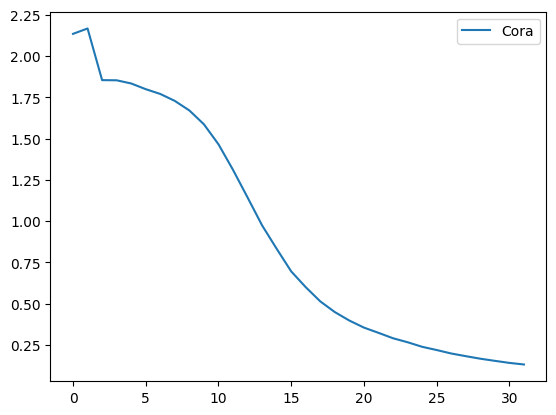

In [9]:
plt.plot(cora_epoch_loss_list, label='Cora')
plt.legend()
plt.show()

In [10]:
acc_train = lm_gnn.evaluate(data_cora, text_inputs, bs_text=32, eval_split='train')
acc_val = lm_gnn.evaluate(data_cora, text_inputs, bs_text=32, eval_split='val')
acc_test = lm_gnn.evaluate(data_cora, text_inputs, bs_text=32, eval_split='test')
print(f'Accuracy: Train {acc_train:.4f}, Val {acc_val:.4f}, Test {acc_test:.4f}')

Accuracy: Train 0.9384, Val 0.8635, Test 0.8819


In [20]:
# store the joint model
# torch.save(lm_gnn.lm_model.state_dict(), './weights/lm_gnn/bert_cora_joint-127ep.pt')
# torch.save(lm_gnn.gnn_model.state_dict(), './weights/lm_gnn/gcn_cora_joint-127ep.pt')

### Pubmed

In [ ]:
# load Pubmed
data_pubmed, text_pubmed = get_raw_text_pubmed(use_text=True)
data_pubmed.num_classes = data_pubmed.y.max().item() + 1      # 3

In [ ]:
set_seed(0)

gcn = GCN(768, 256, data_pubmed.num_classes, num_layers=2)
model_text = BertModel.from_pretrained('bert-base-uncased', max_position_embeddings=512)
model_text.pooler = nn.Identity()

lm_optimizer = torch.optim.AdamW(model_text.parameters(), lr=1e-3)
gcn_optimizer = torch.optim.AdamW(gcn.parameters(), lr=1e-3)

lm_gnn = LM_GNN(model_text.cuda(), gcn.cuda(), lm_optimizer, gcn_optimizer)
lm_gnn.count_parameters()

In [ ]:
# tokenize all texts
text_inputs = tokenizer(text_pubmed, return_tensors='pt', padding=True, truncation=True, max_length=512)          # dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
data_pubmed = data_pubmed.cuda()

# joint training
EPOCHS = 100
pubmed_epoch_loss_list = []

early_stop_ep = 20
epoch_no_improve = 0
val_ep = 5
best_val_acc = 0

for i in tqdm(range(EPOCHS)):
    epoch = i + 1
    
    loss = lm_gnn.train_one_epoch(data_pubmed, text_inputs, bs_text=48)

    print(f'Epoch {epoch}, Loss: {loss:.4f}')
    pubmed_epoch_loss_list.append(loss)

    if epoch % val_ep == 0:
        acc = lm_gnn.evaluate(data_pubmed, text_inputs, bs_text=48, eval_split='val')
        print(f'Epoch {epoch} | Val Acc: {acc:.4f}')

        if acc > best_val_acc:
            best_val_acc = acc
            epoch_no_improve = 0
        else:
            epoch_no_improve += val_ep
        
        if epoch_no_improve >= early_stop_ep:
            print(f'Early stopping at epoch {epoch}')
            break

In [ ]:
# plot loss
plt.plot(cora_epoch_loss_list, label='Cora')
plt.plot(pubmed_epoch_loss_list, label='Pubmed')
plt.legend()
plt.show()

In [ ]:
acc_train = lm_gnn.evaluate(data_pubmed, text_inputs, bs_text=48, eval_split='train')
acc_val = lm_gnn.evaluate(data_pubmed, text_inputs, bs_text=48, eval_split='val')
acc_test = lm_gnn.evaluate(data_pubmed, text_inputs, bs_text=48, eval_split='test')
print(f'Accuracy: Train {acc_train:.4f}, Val {acc_val:.4f}, Test {acc_test:.4f}')

## T5

In [6]:
from transformers import AutoTokenizer, T5EncoderModel
# load Cora
data_cora, text_cora = get_raw_text_cora(use_text=True)
data_cora.num_classes = data_cora.y.max().item() + 1      # 7

/home/kshou/miniconda3/envs/gnn/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/kshou/miniconda3/envs/gnn/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any fe

In [7]:
set_seed(0)
tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")
model_text = T5EncoderModel.from_pretrained("google-t5/t5-small")

gcn = GCN(512, 128, data_cora.num_classes, num_layers=2)
lm_optimizer = torch.optim.AdamW(model_text.parameters(), lr=5e-4)
gcn_optimizer = torch.optim.AdamW(gcn.parameters(), lr=1e-3)

lm_gnn = LM_GNN(model_text.cuda(), gcn.cuda(), lm_optimizer, gcn_optimizer, t5=True)
lm_gnn.count_parameters()

LM: 35.330816M/35.330816M, 100.00%
GNN: 66567/66567, 100.00%


In [8]:
set_seed(0)

# tokenize all texts
text_inputs = tokenizer(text_cora, return_tensors='pt', padding=True, truncation=True, max_length=512)          # dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
data_cora = data_cora.cuda()

# joint training
EPOCHS = 100
cora_epoch_loss_list = []

early_stop_ep = 10
epoch_no_improve = 0
val_ep = 2
best_val_acc = 0

for i in tqdm(range(EPOCHS)):
    epoch = i + 1
    
    loss = lm_gnn.train_one_epoch(data_cora, text_inputs, bs_text=48)
    
    print(f'Epoch {epoch} | Loss: {loss:.4f}')
    cora_epoch_loss_list.append(loss)
    
    if epoch % val_ep == 0:
        acc = lm_gnn.evaluate(data_cora, text_inputs, bs_text=48, eval_split='val')
        print(f'Epoch {epoch} | Val Acc: {acc:.4f}')

        if acc > best_val_acc:
            best_val_acc = acc
            epoch_no_improve = 0
        else:
            epoch_no_improve += val_ep
        
        if epoch_no_improve >= early_stop_ep:
            print(f'Early stopping at epoch {epoch}')
            break

  1%|          | 1/100 [00:27<44:56, 27.24s/it]

Epoch 1 | Loss: 1.9324


100%|██████████| 57/57 [00:18<00:00,  3.12it/s]


Epoch 2 | Loss: 1.8692


  2%|▏         | 2/100 [00:59<49:10, 30.11s/it]

Epoch 2 | Val Acc: 0.3100


  3%|▎         | 3/100 [01:25<45:25, 28.10s/it]

Epoch 3 | Loss: 1.8456


100%|██████████| 57/57 [00:18<00:00,  3.11it/s]


Epoch 4 | Loss: 1.8379


  4%|▍         | 4/100 [01:57<47:36, 29.75s/it]

Epoch 4 | Val Acc: 0.3100


  5%|▌         | 5/100 [02:23<44:50, 28.32s/it]

Epoch 5 | Loss: 1.8300


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 6 | Loss: 1.8185


  6%|▌         | 6/100 [02:55<46:29, 29.68s/it]

Epoch 6 | Val Acc: 0.3100


  7%|▋         | 7/100 [03:21<44:01, 28.40s/it]

Epoch 7 | Loss: 1.8061


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 8 | Loss: 1.7940


  8%|▊         | 8/100 [03:53<45:27, 29.65s/it]

Epoch 8 | Val Acc: 0.3100


  9%|▉         | 9/100 [04:19<43:07, 28.44s/it]

Epoch 9 | Loss: 1.7784


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 10 | Loss: 1.7570


 10%|█         | 10/100 [04:51<44:27, 29.64s/it]

Epoch 10 | Val Acc: 0.3118


 11%|█         | 11/100 [05:17<42:12, 28.45s/it]

Epoch 11 | Loss: 1.7343


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 12 | Loss: 1.7104


 12%|█▏        | 12/100 [05:49<43:27, 29.63s/it]

Epoch 12 | Val Acc: 0.3653


 13%|█▎        | 13/100 [06:15<41:16, 28.46s/it]

Epoch 13 | Loss: 1.6766


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 14 | Loss: 1.6406


 14%|█▍        | 14/100 [06:47<42:28, 29.63s/it]

Epoch 14 | Val Acc: 0.3506


 15%|█▌        | 15/100 [07:13<40:19, 28.47s/it]

Epoch 15 | Loss: 1.6009


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 16 | Loss: 1.5552


 16%|█▌        | 16/100 [07:45<41:28, 29.63s/it]

Epoch 16 | Val Acc: 0.3708


 17%|█▋        | 17/100 [08:11<39:22, 28.47s/it]

Epoch 17 | Loss: 1.5101


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 18 | Loss: 1.4593


 18%|█▊        | 18/100 [08:44<40:29, 29.63s/it]

Epoch 18 | Val Acc: 0.3690


 19%|█▉        | 19/100 [09:09<38:26, 28.47s/it]

Epoch 19 | Loss: 1.4084


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 20 | Loss: 1.3507


 20%|██        | 20/100 [09:42<39:29, 29.62s/it]

Epoch 20 | Val Acc: 0.5332


 21%|██        | 21/100 [10:07<37:28, 28.47s/it]

Epoch 21 | Loss: 1.2924


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 22 | Loss: 1.2292


 22%|██▏       | 22/100 [10:40<38:30, 29.62s/it]

Epoch 22 | Val Acc: 0.5055


 23%|██▎       | 23/100 [11:05<36:31, 28.46s/it]

Epoch 23 | Loss: 1.1661


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 24 | Loss: 1.0999


 24%|██▍       | 24/100 [11:38<37:31, 29.62s/it]

Epoch 24 | Val Acc: 0.5793


 25%|██▌       | 25/100 [12:04<35:34, 28.46s/it]

Epoch 25 | Loss: 1.0344


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 26 | Loss: 0.9713


 26%|██▌       | 26/100 [12:36<36:31, 29.62s/it]

Epoch 26 | Val Acc: 0.6089


 27%|██▋       | 27/100 [13:02<34:37, 28.46s/it]

Epoch 27 | Loss: 0.9082


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 28 | Loss: 0.8492


 28%|██▊       | 28/100 [13:34<35:32, 29.61s/it]

Epoch 28 | Val Acc: 0.6365


 29%|██▉       | 29/100 [14:00<33:40, 28.45s/it]

Epoch 29 | Loss: 0.7923


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 30 | Loss: 0.7377


 30%|███       | 30/100 [14:32<34:33, 29.62s/it]

Epoch 30 | Val Acc: 0.6937


 31%|███       | 31/100 [14:58<32:43, 28.46s/it]

Epoch 31 | Loss: 0.6860


100%|██████████| 57/57 [00:18<00:00,  3.11it/s]


Epoch 32 | Loss: 0.6382


 32%|███▏      | 32/100 [15:30<33:33, 29.61s/it]

Epoch 32 | Val Acc: 0.7362


 33%|███▎      | 33/100 [15:56<31:46, 28.45s/it]

Epoch 33 | Loss: 0.5918


100%|██████████| 57/57 [00:18<00:00,  3.11it/s]


Epoch 34 | Loss: 0.5488


 34%|███▍      | 34/100 [16:28<32:33, 29.60s/it]

Epoch 34 | Val Acc: 0.7565


 35%|███▌      | 35/100 [16:54<30:48, 28.45s/it]

Epoch 35 | Loss: 0.5088


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 36 | Loss: 0.4715


 36%|███▌      | 36/100 [17:26<31:35, 29.62s/it]

Epoch 36 | Val Acc: 0.7601


 37%|███▋      | 37/100 [17:52<29:53, 28.46s/it]

Epoch 37 | Loss: 0.4363


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 38 | Loss: 0.4028


 38%|███▊      | 38/100 [18:24<30:36, 29.61s/it]

Epoch 38 | Val Acc: 0.7860


 39%|███▉      | 39/100 [18:50<28:55, 28.46s/it]

Epoch 39 | Loss: 0.3726


100%|██████████| 57/57 [00:18<00:00,  3.11it/s]


Epoch 40 | Loss: 0.3447


 40%|████      | 40/100 [19:22<29:36, 29.62s/it]

Epoch 40 | Val Acc: 0.7934


 41%|████      | 41/100 [19:48<27:59, 28.47s/it]

Epoch 41 | Loss: 0.3190


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 42 | Loss: 0.2950


 42%|████▏     | 42/100 [20:20<28:38, 29.63s/it]

Epoch 42 | Val Acc: 0.7934


 43%|████▎     | 43/100 [20:46<27:02, 28.47s/it]

Epoch 43 | Loss: 0.2726


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 44 | Loss: 0.2527


 44%|████▍     | 44/100 [21:19<27:39, 29.63s/it]

Epoch 44 | Val Acc: 0.8026


 45%|████▌     | 45/100 [21:44<26:05, 28.47s/it]

Epoch 45 | Loss: 0.2344


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 46 | Loss: 0.2176


 46%|████▌     | 46/100 [22:17<26:39, 29.63s/it]

Epoch 46 | Val Acc: 0.8192


 47%|████▋     | 47/100 [22:42<25:08, 28.47s/it]

Epoch 47 | Loss: 0.2018


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 48 | Loss: 0.1873


 48%|████▊     | 48/100 [23:15<25:40, 29.62s/it]

Epoch 48 | Val Acc: 0.8358


 49%|████▉     | 49/100 [23:40<24:11, 28.47s/it]

Epoch 49 | Loss: 0.1745


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 50 | Loss: 0.1625


 50%|█████     | 50/100 [24:13<24:41, 29.63s/it]

Epoch 50 | Val Acc: 0.8413


 51%|█████     | 51/100 [24:39<23:15, 28.47s/it]

Epoch 51 | Loss: 0.1513


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 52 | Loss: 0.1412


 52%|█████▏    | 52/100 [25:11<23:41, 29.62s/it]

Epoch 52 | Val Acc: 0.8469


 53%|█████▎    | 53/100 [25:37<22:17, 28.47s/it]

Epoch 53 | Loss: 0.1320


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 54 | Loss: 0.1238


 54%|█████▍    | 54/100 [26:09<22:42, 29.62s/it]

Epoch 54 | Val Acc: 0.8395


 55%|█████▌    | 55/100 [26:35<21:20, 28.46s/it]

Epoch 55 | Loss: 0.1160


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 56 | Loss: 0.1089


 56%|█████▌    | 56/100 [27:07<21:43, 29.61s/it]

Epoch 56 | Val Acc: 0.8469


 57%|█████▋    | 57/100 [27:33<20:23, 28.46s/it]

Epoch 57 | Loss: 0.1025


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 58 | Loss: 0.0964


 58%|█████▊    | 58/100 [28:05<20:43, 29.61s/it]

Epoch 58 | Val Acc: 0.8450


 59%|█████▉    | 59/100 [28:31<19:26, 28.46s/it]

Epoch 59 | Loss: 0.0909


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 60 | Loss: 0.0857


 60%|██████    | 60/100 [29:03<19:44, 29.61s/it]

Epoch 60 | Val Acc: 0.8413


 61%|██████    | 61/100 [29:29<18:29, 28.45s/it]

Epoch 61 | Loss: 0.0808


100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Epoch 62 | Loss: 0.0764


 61%|██████    | 61/100 [30:01<19:11, 29.54s/it]

Epoch 62 | Val Acc: 0.8450
Early stopping at epoch 62


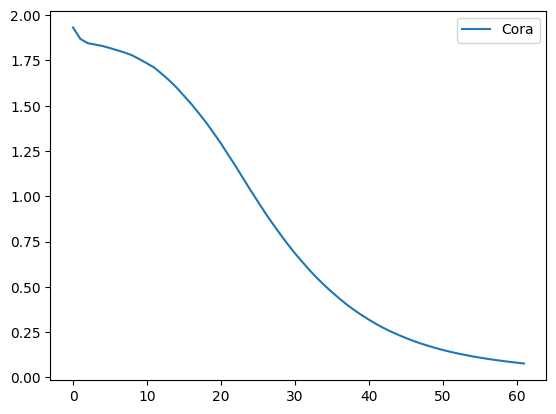

In [9]:
# plot loss
plt.plot(cora_epoch_loss_list, label='Cora')
plt.legend()
plt.show()

In [10]:
acc_train = lm_gnn.evaluate(data_cora, text_inputs, bs_text=48, eval_split='train')
acc_val = lm_gnn.evaluate(data_cora, text_inputs, bs_text=48, eval_split='val')
acc_test = lm_gnn.evaluate(data_cora, text_inputs, bs_text=48, eval_split='test')
print(f'Accuracy: Train {acc_train:.4f}, Val {acc_val:.4f}, Test {acc_test:.4f}')

Accuracy: Train 0.9144, Val 0.8450, Test 0.8524
